# **Multi-Class Object Detection with using Faster-rcnn**

---

---

## **Import utilities**

In [1]:
import os
import collections
import pandas as pd
import numpy as np
import functools
import matplotlib.pyplot as plt
import cv2

from sklearn import preprocessing


import xml.etree.ElementTree as ET

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data import SequentialSampler

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"venkataarunkumar","key":"cdc91b7894548e90c531b61b8ac895a7"}'}

In [4]:
!pip install -q kaggle

In [5]:
!mkdir -p ~/.kaggle

In [6]:
!cp kaggle.json ~/.kaggle/

In [7]:
!chmod 600 /root/.kaggle/kaggle.json

In [8]:
!pwd

/content


In [9]:
!kaggle datasets list

ref                                                            title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
-------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
thedrcat/daigt-v2-train-dataset                                DAIGT V2 Train Dataset                              29MB  2023-11-16 01:38:36            909        106  1.0              
muhammadbinimran/housing-price-prediction-data                 Housing Price Prediction Data                      763KB  2023-11-21 17:56:32           3113         71  1.0              
carlmcbrideellis/llm-7-prompt-training-dataset                 LLM: 7 prompt training dataset                      41MB  2023-11-15 07:32:56           1322        104  1.0              
thedrcat/daigt-proper-train-dataset                            DAIGT P

In [10]:
!kaggle datasets download -d huanghanchina/pascal-voc-2012

 99% 3.61G/3.63G [00:47<00:00, 101MB/s]
100% 3.63G/3.63G [00:47<00:00, 82.4MB/s]


In [13]:
!unzip /content/pascal-voc-2012.zip

Streaming output truncated to the last 5000 lines.
  inflating: voc2012/VOC2012/SegmentationClass/2008_001829.png  
  inflating: voc2012/VOC2012/SegmentationClass/2008_001874.png  
  inflating: voc2012/VOC2012/SegmentationClass/2008_001876.png  
  inflating: voc2012/VOC2012/SegmentationClass/2008_001882.png  
  inflating: voc2012/VOC2012/SegmentationClass/2008_001885.png  
  inflating: voc2012/VOC2012/SegmentationClass/2008_001895.png  
  inflating: voc2012/VOC2012/SegmentationClass/2008_001896.png  
  inflating: voc2012/VOC2012/SegmentationClass/2008_001926.png  
  inflating: voc2012/VOC2012/SegmentationClass/2008_001966.png  
  inflating: voc2012/VOC2012/SegmentationClass/2008_001971.png  
  inflating: voc2012/VOC2012/SegmentationClass/2008_001992.png  
  inflating: voc2012/VOC2012/SegmentationClass/2008_001997.png  
  inflating: voc2012/VOC2012/SegmentationClass/2008_002032.png  
  inflating: voc2012/VOC2012/SegmentationClass/2008_002043.png  
  inflating: voc2012/VOC2012/Segmentati

In [16]:
BASE_PATH = "/content/VOC2012"
XML_PATH = os.path.join(BASE_PATH, "Annotations")
IMG_PATH = os.path.join(BASE_PATH, "JPEGImages")
XML_FILES = [os.path.join(XML_PATH, f) for f in os.listdir(XML_PATH)]


## **Extract info. from xml files**

In [17]:
class XmlParser(object):

    def __init__(self,xml_file):

        self.xml_file = xml_file
        self._root = ET.parse(self.xml_file).getroot()
        self._objects = self._root.findall("object")
        # path to the image file as describe in the xml file
        self.img_path = os.path.join(IMG_PATH, self._root.find('filename').text)
        # image id
        self.image_id = self._root.find("filename").text
        # names of the classes contained in the xml file
        self.names = self._get_names()
        # coordinates of the bounding boxes
        self.boxes = self._get_bndbox()

    def parse_xml(self):
        """"Parse the xml file returning the root."""

        tree = ET.parse(self.xml_file)
        return tree.getroot()

    def _get_names(self):

        names = []
        for obj in self._objects:
            name = obj.find("name")
            names.append(name.text)

        return np.array(names)

    def _get_bndbox(self):

        boxes = []
        for obj in self._objects:
            coordinates = []
            bndbox = obj.find("bndbox")
            coordinates.append(np.int32(bndbox.find("xmin").text))
            coordinates.append(np.int32(np.float32(bndbox.find("ymin").text)))
            coordinates.append(np.int32(bndbox.find("xmax").text))
            coordinates.append(np.int32(bndbox.find("ymax").text))
            boxes.append(coordinates)

        return np.array(boxes)

## **Make dataframe from extracted information**

In [18]:
def xml_files_to_df(xml_files):

    """"Return pandas dataframe from list of XML files."""

    names = []
    boxes = []
    image_id = []
    xml_path = []
    img_path = []
    for file in xml_files:
        xml = XmlParser(file)
        names.extend(xml.names)
        boxes.extend(xml.boxes)
        image_id.extend([xml.image_id] * len(xml.names))
        xml_path.extend([xml.xml_file] * len(xml.names))
        img_path.extend([xml.img_path] * len(xml.names))
    a = {"image_id": image_id,
         "names": names,
         "boxes": boxes,
         "xml_path":xml_path,
         "img_path":img_path}

    df = pd.DataFrame.from_dict(a, orient='index')
    df = df.transpose()

    return df

df = xml_files_to_df(XML_FILES)
df.head()

image_id   names                 boxes  \
0  2009_000670.jpg   sheep  [209, 315, 276, 421]   
1  2009_000670.jpg   sheep   [82, 283, 175, 422]   
2  2008_000655.jpg  person    [1, 233, 146, 480]   
3  2008_000655.jpg  person     [97, 3, 320, 480]   
4  2011_005763.jpg  person   [159, 80, 361, 256]   

                                       xml_path  \
0  /content/VOC2012/Annotations/2009_000670.xml   
1  /content/VOC2012/Annotations/2009_000670.xml   
2  /content/VOC2012/Annotations/2008_000655.xml   
3  /content/VOC2012/Annotations/2008_000655.xml   
4  /content/VOC2012/Annotations/2011_005763.xml   

                                      img_path  
0  /content/VOC2012/JPEGImages/2009_000670.jpg  
1  /content/VOC2012/JPEGImages/2009_000670.jpg  
2  /content/VOC2012/JPEGImages/2008_000655.jpg  
3  /content/VOC2012/JPEGImages/2008_000655.jpg  
4  /content/VOC2012/JPEGImages/2011_005763.jpg

---

In [19]:
# check values for per class
df['names'].value_counts()

person         17401
chair           3056
car             2492
dog             1598
bottle          1561
cat             1277
bird            1271
pottedplant     1202
sheep           1084
boat            1059
aeroplane       1002
tvmonitor        893
sofa             841
bicycle          837
horse            803
motorbike        801
diningtable      800
cow              771
train            704
bus              685
Name: names, dtype: int64

In [20]:

# remove .jpg extension from image_id
df['img_id'] = df['image_id'].apply(lambda x:x.split('.')).map(lambda x:x[0])
df.drop(columns=['image_id'], inplace=True)
df.head()

names                 boxes                                      xml_path  \
0   sheep  [209, 315, 276, 421]  /content/VOC2012/Annotations/2009_000670.xml   
1   sheep   [82, 283, 175, 422]  /content/VOC2012/Annotations/2009_000670.xml   
2  person    [1, 233, 146, 480]  /content/VOC2012/Annotations/2008_000655.xml   
3  person     [97, 3, 320, 480]  /content/VOC2012/Annotations/2008_000655.xml   
4  person   [159, 80, 361, 256]  /content/VOC2012/Annotations/2011_005763.xml   

                                      img_path       img_id  
0  /content/VOC2012/JPEGImages/2009_000670.jpg  2009_000670  
1  /content/VOC2012/JPEGImages/2009_000670.jpg  2009_000670  
2  /content/VOC2012/JPEGImages/2008_000655.jpg  2008_000655  
3  /content/VOC2012/JPEGImages/2008_000655.jpg  2008_000655  
4  /content/VOC2012/JPEGImages/2011_005763.jpg  2011_005763

In [21]:
# classes need to be in int form so we use LabelEncoder for this task
enc = preprocessing.LabelEncoder()
df['labels'] = enc.fit_transform(df['names'])
df['labels'] = np.stack(df['labels'][i]+1 for i in range(len(df['labels'])))

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


In [22]:
classes = df[['names','labels']].value_counts()
classes

names        labels
person       15        17401
chair        9          3056
car          7          2492
dog          12         1598
bottle       5          1561
cat          8          1277
bird         3          1271
pottedplant  16         1202
sheep        17         1084
boat         4          1059
aeroplane    1          1002
tvmonitor    20          893
sofa         18          841
bicycle      2           837
horse        13          803
motorbike    14          801
diningtable  11          800
cow          10          771
train        19          704
bus          6           685
dtype: int64

In [23]:
# make dictionary for class objects so we can call objects by their keys.
classes= {1:'aeroplane',2:'bicycle',3:'bird',4:'boat',5:'bottle',6:'bus',7:'car',8:'cat',9:'chair',10:'cow',11:'diningtable',12:'dog',13:'horse',14:'motorbike',15:'person',16:'pottedplant',17:'sheep',18:'sofa',19:'train',20:'tvmonitor'}

In [24]:
# bounding box coordinates point need to be in separate columns

df['xmin'] = -1
df['ymin'] = -1
df['xmax'] = -1
df['ymax'] = -1

df[['xmin','ymin','xmax','ymax']]=np.stack(df['boxes'][i] for i in range(len(df['boxes'])))

df.drop(columns=['boxes'], inplace=True)
df['xmin'] = df['xmin'].astype(np.float)
df['ymin'] = df['ymin'].astype(np.float)
df['xmax'] = df['xmax'].astype(np.float)
df['ymax'] = df['ymax'].astype(np.float)

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):
<ipython-input-24-c073529ba8ee>:11: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df['xmin'] = df['xmin'].astype(np.float)
<ipython-input-24-c073529ba8ee>:12: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavi

In [25]:
# drop names column since we dont need it anymore
df.drop(columns=['names'], inplace=True)
df.head()

xml_path  \
0  /content/VOC2012/Annotations/2009_000670.xml   
1  /content/VOC2012/Annotations/2009_000670.xml   
2  /content/VOC2012/Annotations/2008_000655.xml   
3  /content/VOC2012/Annotations/2008_000655.xml   
4  /content/VOC2012/Annotations/2011_005763.xml   

                                      img_path       img_id  labels   xmin  \
0  /content/VOC2012/JPEGImages/2009_000670.jpg  2009_000670      17  209.0   
1  /content/VOC2012/JPEGImages/2009_000670.jpg  2009_000670      17   82.0   
2  /content/VOC2012/JPEGImages/2008_000655.jpg  2008_000655      15    1.0   
3  /content/VOC2012/JPEGImages/2008_000655.jpg  2008_000655      15   97.0   
4  /content/VOC2012/JPEGImages/2011_005763.jpg  2011_005763      15  159.0   

    ymin   xmax   ymax  
0  315.0  276.0  421.0  
1  283.0  175.0  422.0  
2  233.0  146.0  480.0  
3    3.0  320.0  480.0  
4   80.0  361.0  256.0

In [26]:
len(df['img_id'].unique())

17125

## **Separate train and validation data**

In [27]:
image_ids = df['img_id'].unique()
valid_ids = image_ids[-4000:]
train_ids = image_ids[:-4000]
len(train_ids)

13125

In [28]:
valid_df = df[df['img_id'].isin(valid_ids)]
train_df = df[df['img_id'].isin(train_ids)]
valid_df.shape, train_df.shape

((9475, 8), (30663, 8))

## **Make dataset by Dataset Module**

In [29]:
class VOCDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['img_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        records = self.df[self.df['img_id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        rows, cols = image.shape[:2]

        boxes = records[['xmin', 'ymin', 'xmax', 'ymax']].values


        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        label = records['labels'].values
        labels = torch.as_tensor(label, dtype=torch.int64)

        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        # target['masks'] = None
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']

            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1,0)

            return image, target

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [30]:
def get_transform_train():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        ToTensorV2(p=1.0)
    ], bbox_params={'format':'pascal_voc', 'label_fields': ['labels']})

def get_transform_valid():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields':['labels']})

In [31]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = VOCDataset(train_df, IMG_PATH , get_transform_train())
valid_dataset = VOCDataset(valid_df, IMG_PATH, get_transform_valid())


# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()


train_data_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# **View sample**

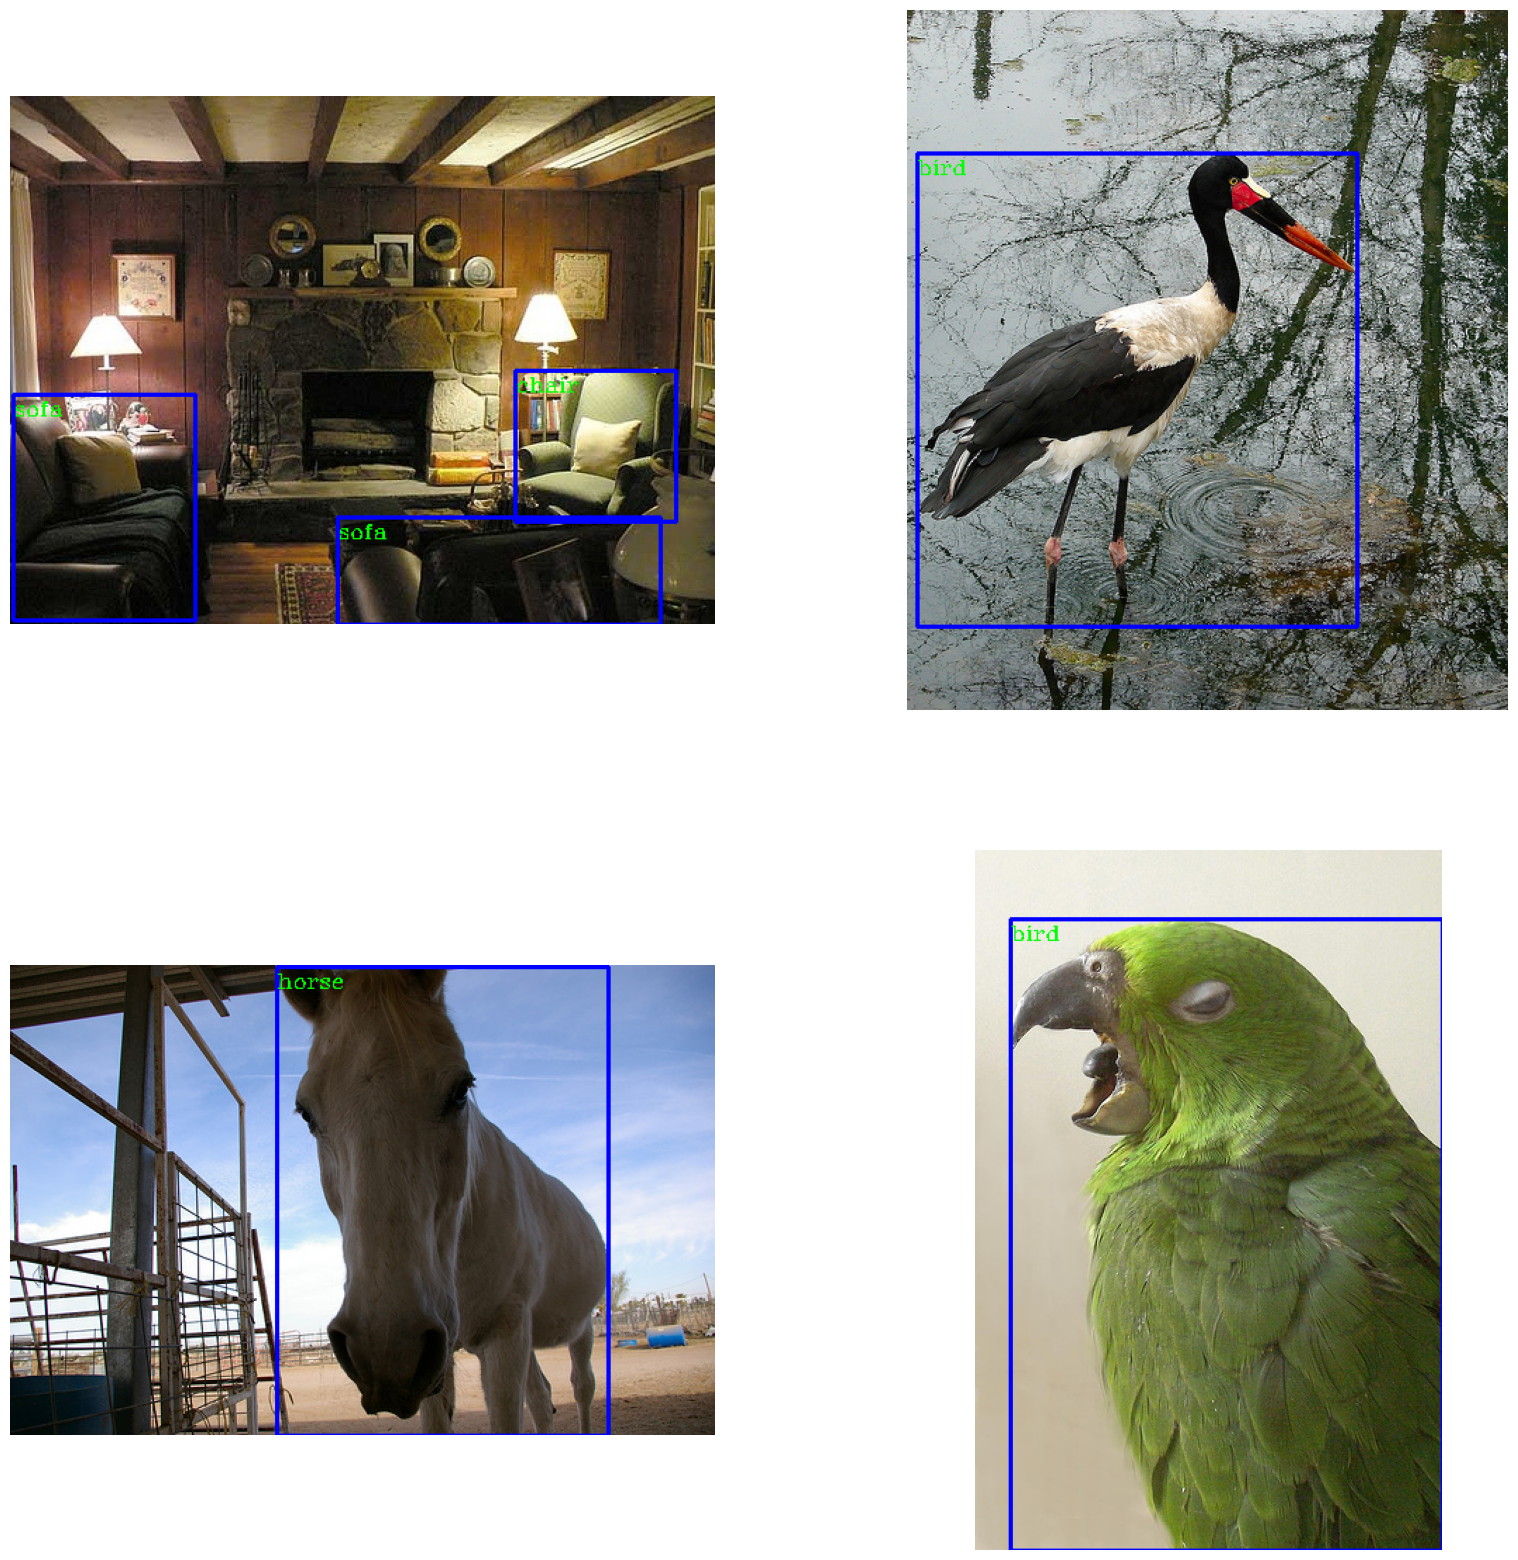

In [33]:
images, targets= next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

plt.figure(figsize=(20,20))
for i, (image, target) in enumerate(zip(images, targets)):
    plt.subplot(2,2, i+1)
    boxes = targets[i]['boxes'].cpu().numpy().astype(np.int32)
    sample = images[i].permute(1,2,0).cpu().numpy()
    names = targets[i]['labels'].cpu().numpy().astype(np.int64)
    for i,box in enumerate(boxes):
        cv2.rectangle(sample,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (0, 0, 220), 2)
        cv2.putText(sample, classes[names[i]], (box[0],box[1]+15),cv2.FONT_HERSHEY_COMPLEX ,0.5,(0,220,0),1,cv2.LINE_AA)

    plt.axis('off')
    plt.imshow(sample)




# Download pretrained model

In [34]:
# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 87.8MB/s]


In [35]:
num_classes = 21

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)


In [36]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

## **Download modules for model training**

In [37]:
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-dckn90vd
  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-dckn90vd
  Resolved https://github.com/cocodataset/cocoapi.git to commit 8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9
  Preparing metadata (setup.py) ... done
  Created wheel for pycocotools: filename=pycocotools-2.0-cp310-cp310-linux_x86_64.whl size=375455 sha256=f416b291e0fe5a412f76c6187e9220f68ba8c92fb00aff16488b79e26fd87fbd
  Stored in directory: /tmp/pip-ephem-wheel-cache-6foeinw2/wheels/39/61/b4/480fbddb4d3d6bc34083e7397bc6f5d1381f79acc68e9f3511
Successfully built pycocotools
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0.7
    Uninstalling pycocotools-2.0.7:
      Successfully uninstalled pycocotools-2.0.7


In [38]:
!git clone https://github.com/pytorch/vision.git
!cd vision;cp references/detection/utils.py ../;cp references/detection/transforms.py ../;cp references/detection/coco_eval.py ../;cp references/detection/engine.py ../;cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 433278, done.
remote: Counting objects: 100% (13740/13740), done.
remote: Compressing objects: 100% (785/785), done.
remote: Total 433278 (delta 12993), reused 13646 (delta 12934), pack-reused 419538
Receiving objects: 100% (433278/433278), 858.27 MiB | 4.19 MiB/s, done.
Resolving deltas: 100% (402093/402093), done.


In [39]:
from engine import train_one_epoch, evaluate
import utils

## **Train object detection model**

In [40]:
# let's train it for 2 epochs
num_epochs = 1

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, train_data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, valid_data_loader, device=device)

Epoch: [0]  [   0/3282]  eta: 8:54:13  lr: 0.000010  loss: 3.2497 (3.2497)  loss_classifier: 3.0902 (3.0902)  loss_box_reg: 0.1509 (0.1509)  loss_objectness: 0.0062 (0.0062)  loss_rpn_box_reg: 0.0025 (0.0025)  time: 9.7664  data: 0.4681  max mem: 5376
Epoch: [0]  [  10/3282]  eta: 1:53:13  lr: 0.000060  loss: 3.4095 (3.4260)  loss_classifier: 3.0597 (3.0456)  loss_box_reg: 0.3847 (0.3468)  loss_objectness: 0.0098 (0.0121)  loss_rpn_box_reg: 0.0230 (0.0215)  time: 2.0762  data: 0.0706  max mem: 6638
Epoch: [0]  [  20/3282]  eta: 1:31:23  lr: 0.000110  loss: 3.3101 (3.3379)  loss_classifier: 2.9809 (2.9876)  loss_box_reg: 0.3255 (0.3221)  loss_objectness: 0.0104 (0.0118)  loss_rpn_box_reg: 0.0176 (0.0163)  time: 1.2769  data: 0.0310  max mem: 6638
Epoch: [0]  [  30/3282]  eta: 1:25:05  lr: 0.000160  loss: 3.1165 (3.2159)  loss_classifier: 2.7679 (2.8812)  loss_box_reg: 0.2579 (0.3053)  loss_objectness: 0.0104 (0.0131)  loss_rpn_box_reg: 0.0068 (0.0163)  time: 1.2913  data: 0.0246  max me

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/numpy/lib/arraysetops.py:272: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
 

AssertionError: ignored

In [41]:
torch.save(model.state_dict(), 'faster_rcnn_state.pth')

# **Test model**

In [42]:
# load  a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=False)

WEIGHTS_FILE = "./faster_rcnn_state.pth"

num_classes = 21

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Load the traines weights
model.load_state_dict(torch.load(WEIGHTS_FILE))

model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and may be removed in the future, please use 'weights_backbone' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights_backbone' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to 

In [43]:
def obj_detector(img):
    img = cv2.imread(img, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)


    img /= 255.0
    img = torch.from_numpy(img)
    img = img.unsqueeze(0)
    img = img.permute(0,3,1,2)

    model.eval()

    detection_threshold = 0.70

    img = list(im.to(device) for im in img)
    output = model(img)

    for i , im in enumerate(img):
        boxes = output[i]['boxes'].data.cpu().numpy()
        scores = output[i]['scores'].data.cpu().numpy()
        labels = output[i]['labels'].data.cpu().numpy()

        labels = labels[scores >= detection_threshold]
        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        scores = scores[scores >= detection_threshold]

        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]

    sample = img[0].permute(1,2,0).cpu().numpy()
    sample = np.array(sample)
    boxes = output[0]['boxes'].data.cpu().numpy()
    name = output[0]['labels'].data.cpu().numpy()
    scores = output[0]['scores'].data.cpu().numpy()
    boxes = boxes[scores >= detection_threshold].astype(np.int32)
    names = name.tolist()

    return names, boxes, sample

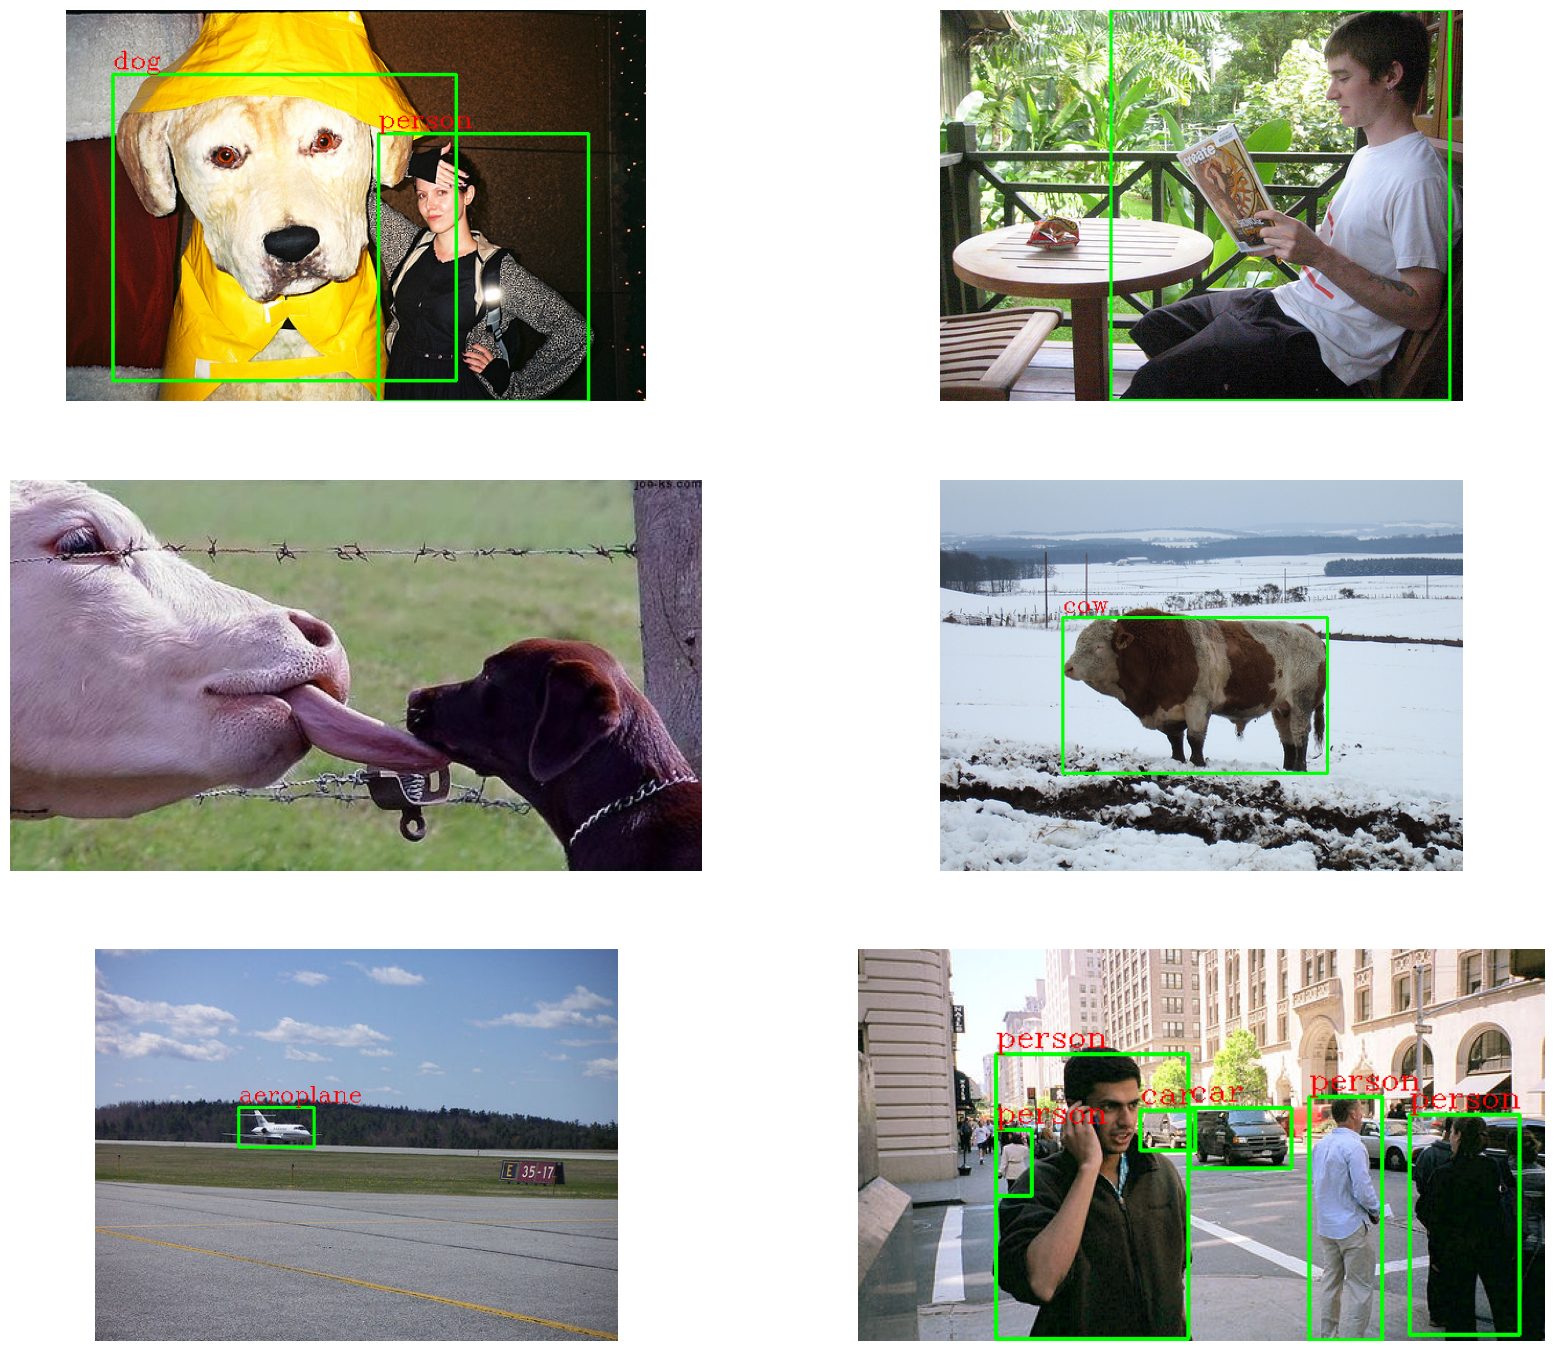

In [44]:
import random
pred_path = "/content/voc2012/VOC2012/JPEGImages/"


files = []
for i in range(6):
  files.append(pred_path + random.choice(os.listdir(pred_path)))
# pred_files = [os.path.join(pred_path,f) for f in os.listdir(pred_path)]

plt.figure(figsize=(20,60))
for i, images in enumerate(files):
    if i > 19:break
    plt.subplot(10,2,i+1)
    names,boxes,sample = obj_detector(images)
    for i,box in enumerate(boxes):
        cv2.rectangle(sample,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (0, 220, 0), 2)
        cv2.putText(sample, classes[names[i]], (box[0],box[1]-5),cv2.FONT_HERSHEY_COMPLEX ,0.7,(220,0,0),1,cv2.LINE_AA)

    plt.axis('off')
    plt.imshow(sample)
#     plt.savefig('save_image.png', bbox_inches='tight')  # if you want to save result